In [ ]:
# Connect google drive to google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
main_datasets_path = '/content/drive/MyDrive/AVD/Trabajos_3_4/Datasets/'

In [ ]:
!cp -r /content/drive/MyDrive/AVD/Trabajos_3_4/Datasets/posters /content

In [ ]:
!pip install lime
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=97b60a4ddcaad4291d8af391766fa1998755695a942019e92269c1573d7141d7
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 4.6 MB/s eta 0:00:00


# Predecir género de películas usando los posters

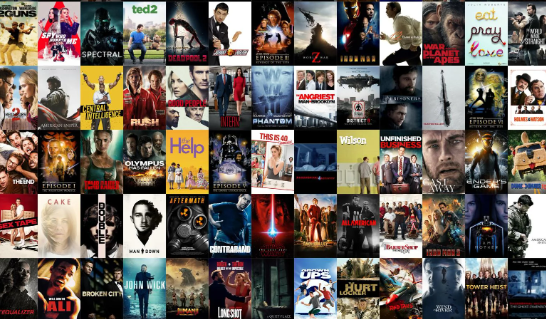

En esta parte del trabajo vamos a entrenar algún modelo de clasificación para realizar un clasificación multiclase de las películas tomando como entrada los posters de estas. Para ello se proporciona el dataset con los posters en una carpeta junto a los datos y un csv "posters_genres.csv" que contiene los nombres de los posters en una columna y los géneros de cada películas en la otra.

# Preprocesamiento y creación de los datos de Training y Test

Una vez descargado el dataset y generado un CSV limpio con los datos realmente disponibles vamos ahora a preprocesar la información de las etiquetas multiclase (géneros de las películas) para crear los conjuntos de entrenamiento y validación para nuestro modelo de inteligencia artificial clasificador de géneros. El problema es multiclase dado que cada película tiene asociados más de un género (no confundir con problema con muchas clases y sólo una asociada a cada imagen).

In [ ]:
import pandas as pd
import numpy as np
import io
import sys
import os.path
from tqdm import tqdm
from os import listdir
from PIL import Image
import glob
from ast import literal_eval

In [ ]:
df = pd.read_csv(main_datasets_path+"posters_genres.csv")
df.head()

poster_name  \
0                                   Avatar.jpg   
1  Pirates_of_the_Caribbean_At_World_s_End.jpg   
2                                  Spectre.jpg   
3                    The_Dark_Knight_Rises.jpg   
4                              John_Carter.jpg   

                                              genres  
0  ['Action', 'Adventure', 'Fantasy', 'Science Fi...  
1                 ['Adventure', 'Fantasy', 'Action']  
2                   ['Action', 'Adventure', 'Crime']  
3           ['Action', 'Crime', 'Drama', 'Thriller']  
4         ['Action', 'Adventure', 'Science Fiction']

In [ ]:
df.shape

(3618, 2)

In [ ]:
# How many images actually downloaded
image_list = []
for file in glob.glob("posters/*.jpg"):
    image_list.append("posters/"+file)

print("Number of files found:", len(image_list))

Number of files found: 3618


In [ ]:
# Función para convertir la cadena que parece una lista en una lista real
def find_genres(genre_string):
    try:
        # Convertir la cadena a una lista real
        genres = literal_eval(genre_string)
    except ValueError:
        # En caso de error (por ejemplo, si es NaN o un formato inesperado), devuelve una lista vacía
        genres = []
    return genres

# Preparar la lista de todos los géneros
all_genre = []
for genre_string in df['genres']:
    all_genre.extend(find_genres(genre_string))

# Contar frecuencia de cada género
uniq, counts = np.unique(all_genre, return_counts=True)
print("Number of unique genres:", len(uniq))
print("Unique genres are:", uniq)
genre_dict = dict(zip(uniq, counts))

# Eliminar el género vacío
uniq = np.delete(uniq, np.where(uniq == ''))  # Elimina el género vacío de la lista de géneros únicos
print("Filtered unique genres:", uniq)

Number of unique genres: 20
Unique genres are: ['' 'Action' 'Adventure' 'Animation' 'Comedy' 'Crime' 'Documentary'
 'Drama' 'Family' 'Fantasy' 'Foreign' 'History' 'Horror' 'Music' 'Mystery'
 'Romance' 'Science Fiction' 'Thriller' 'War' 'Western']
Filtered unique genres: ['Action' 'Adventure' 'Animation' 'Comedy' 'Crime' 'Documentary' 'Drama'
 'Family' 'Fantasy' 'Foreign' 'History' 'Horror' 'Music' 'Mystery'
 'Romance' 'Science Fiction' 'Thriller' 'War' 'Western']


In [ ]:
# Función para convertir la cadena que parece una lista en una lista real
def find_genres(genre_string):
    try:
        # Convertir la cadena a una lista real
        genres = literal_eval(genre_string)
    except ValueError:
        # En caso de error, devuelve una lista vacía
        genres = []
    return genres

# Función para crear las etiquetas multi-hot
def multi_hot_encoded_labels(path, genre):
    genre_set = set(find_genres(genre))
    encoded = [1 if g in genre_set else 0 for g in uniq]
    return ['posters/'+path] + encoded + [genre]

# Preparar los datos para el multi-hot encoding
all_data = []
for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    all_data.append(multi_hot_encoded_labels(row['poster_name'], row['genres']))

# Nombres de columnas para el DataFrame final
col_names = ['Img-paths'] + list(uniq) + ['Overal_Genre']

# Guardar los datos codificados en formato CSV
df_encoded = pd.DataFrame(all_data, columns=col_names)
df_encoded.to_csv("Multi_hot_encoded_data.csv", index=False, sep="#")

100%|██████████| 3618/3618 [00:00<00:00, 4669.40it/s]


In [ ]:
# Dividir los datos en entrenamiento, validación y prueba
random_seed = 50
train_df = df_encoded.sample(frac=0.80, random_state=random_seed)
tmp_df = df_encoded.drop(train_df.index)
test_df = tmp_df.sample(frac=0.2, random_state=random_seed)
valid_df = tmp_df.drop(test_df.index)

print("Train_df=", len(train_df))
print("Val_df=", len(valid_df))
print("Test_df=", len(test_df))

# Guardar los conjuntos de entrenamiento, prueba y validación
train_df.to_csv("Train.csv", index=False, sep="#")
test_df.to_csv("Test.csv", index=False, sep="#")
valid_df.to_csv("Valid.csv", index=False, sep="#")

Train_df= 2894
Val_df= 579
Test_df= 145


In [ ]:
train_df.head()

Img-paths  Action  Adventure  Animation  Comedy  \
3391     posters/My_Summer_of_Love.jpg       0          0          0       0   
2101             posters/Leap_Year.jpg       0          0          0       1   
1783            posters/Gettysburg.jpg       0          0          0       0   
2135                 posters/Honey.jpg       0          0          0       0   
2229  posters/When_Harry_Met_Sally.jpg       0          0          0       1   

      Crime  Documentary  Drama  Family  Fantasy  ...  History  Horror  Music  \
3391      0            0      1       0        0  ...        0       0      0   
2101      0            0      0       0        0  ...        0       0      0   
1783      0            0      1       0        0  ...        1       0      0   
2135      0            0      0       1        0  ...        0       0      1   
2229      0            0      1       0        0  ...        0       0      0   

      Mystery  Romance  Science Fiction  Thriller  War  Western  \
3391        0        1                0         1    0        0   
2101        0        1                0         0    0        0   
1783        0        0                0         0    1        0   
2135        0        1                0         0    0        0   
2229        0        1                0         0    0        0   

                          Overal_Genre  
3391  ['Drama', 'Thriller', 'Romance']  
2101             ['Romance', 'Comedy']  
1783       ['War', 'Drama', 'History']  
2135    ['Romance', 'Music', 'Family']  
2229    ['Comedy', 'Romance', 'Drama']  

[5 rows x 21 columns]

# Entrenamiento del modelo

Ya tenemos preparados los datos de entrada y las etiquetas para la clasificación. Se van a definir ahora los modelos a emplear para la clasificación y el código para el entrenamiento y validación del modelo. Para ello seguiremos los pasos de todo proyecto Pytorch:

1. Creación de los dataloaders.
2. Creación del modelo de red neuronal.
3. Definición de parámetros de entrenamiento (optimizado, loss function...).
4. Loop de entrenamiento y validación del modelo.
5. Almacenamiento de modelo entrenado.
6. Uso del modelo entrenado con nuevos datos para predicción.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import models, transforms
import copy
import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

### 1. Creación del dataloader

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0] # Asumiendo que el primer campo es la ruta de la imagen
        image = Image.open(img_name).convert('RGB')
        label = np.array(self.dataframe.iloc[idx, 1:20]).astype('float32') # Ajusta los índices según tu DataFrame
        if self.transform:
            image = self.transform(image)

        label_tensor = torch.tensor(label, dtype=torch.float32)
        return image, label_tensor

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((280, 190)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_df = pd.read_csv("Train.csv", delimiter="#")
val_df = pd.read_csv("Valid.csv", delimiter="#")

# Asumiendo que train_df y val_df son tus DataFrames
train_dataset = CustomDataset(dataframe=train_df, transform=transform)
val_dataset = CustomDataset(dataframe=val_df, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=256, shuffle=False)

data_loader = {}
data_loader['train'] = train_loader
data_loader['valid'] = val_loader

### 2. Creación del modelo de red neuronal

In [ ]:
# Cargar la arquitectura preentrenada de ResNet-18
model = models.resnet18(weights=None)
# Cambiar la última capa de clasificación
num_ftrs = model.fc.in_features  # Obtener el número de características de entrada de la última capa FC
model.fc = nn.Linear(num_ftrs, 19)  # Reemplazar la última capa FC para 28 clases
model = model.to(device)

### 3. Loop de entrenamiento y validación

In [ ]:
def train_model(model, criterion, optimizer, device, data_loader, n_epochs=10):

    best_model_wts = copy.deepcopy(model.state_dict())
    valid_loss_min = np.Inf

    # Initialize lists for storing metrics
    history = {
        "train_loss": [],
        "valid_loss": [],
    }

    for epoch in range(1, n_epochs + 1):
        since = time.time()

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in data_loader[phase]:
                inputs, labels = inputs.to(device), labels.to(device).float()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

                preds = torch.sigmoid(outputs).data > 0.75
                running_corrects += torch.sum(preds == labels.data.byte()).double()

                total_samples += inputs.size(0)

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / (total_samples * labels.size(1))  # Total correct predictions / (Batch_size * Num_classes)

            history[f"{phase}_loss"].append(epoch_loss)
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            elapsed_time = time.time() - since
            print(f"Epoch {epoch} completed in {elapsed_time // 60}m {elapsed_time % 60}s")

    model.load_state_dict(best_model_wts)
    return model, history

### 4. Definición de parámetros de entrenamiento

In [ ]:
# Define the loss function and optimizer
learning_rate = 0.0001  # Learning rate
training_epochs = 10   # Number of epochs
model_name = "model_posters_resnet18"  # Name of the model to store in disk
criterion = torch.nn.BCEWithLogitsLoss() # Loss Function for the network training
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Optimizer for training

In [ ]:
print('Training and evaluating model, this will take some time to complete!!!')
model, history = train_model(model, criterion, optimizer, device, data_loader, n_epochs=training_epochs)

Training and evaluating model, this will take some time to complete!!!
Train Loss: 0.5451 Acc: 0.8632
Epoch 1 completed in 0.0m 24.683598518371582s
Valid Loss: 0.5133 Acc: 0.8608
Epoch 1 completed in 0.0m 28.055756092071533s
Train Loss: 0.3770 Acc: 0.8639
Epoch 2 completed in 0.0m 18.876544713974s
Valid Loss: 0.3894 Acc: 0.8635
Epoch 2 completed in 0.0m 20.859496355056763s
Train Loss: 0.3313 Acc: 0.8648
Epoch 3 completed in 0.0m 18.104355096817017s
Valid Loss: 0.3378 Acc: 0.8626
Epoch 3 completed in 0.0m 20.687352657318115s
Train Loss: 0.3142 Acc: 0.8661
Epoch 4 completed in 0.0m 16.612725019454956s
Valid Loss: 0.3228 Acc: 0.8619
Epoch 4 completed in 0.0m 18.57842755317688s
Train Loss: 0.3042 Acc: 0.8659
Epoch 5 completed in 0.0m 16.413843631744385s
Valid Loss: 0.3200 Acc: 0.8652
Epoch 5 completed in 0.0m 18.444928646087646s
Train Loss: 0.2973 Acc: 0.8678
Epoch 6 completed in 0.0m 16.658647060394287s
Valid Loss: 0.3149 Acc: 0.8631
Epoch 6 completed in 0.0m 19.034713745117188s
Train Los

### 5. Almacenamiento del modelo

In [ ]:
# Save the checkpoint
def save_checkpoint(model, optimizer, model_file):
    parameters = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer,
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(parameters, model_file)

In [ ]:
print('Saving best model...')
save_checkpoint(model, optimizer, model_name+".pth")

Saving best model...


### 6. Uso del modelo entrenado para predicción con nuevos datos

In [ ]:
# Cargar la arquitectura preentrenada de ResNet-18
model = models.resnet18(pretrained=False)
# Cambiar la última capa de clasificación
num_ftrs = model.fc.in_features  # Obtener el número de características de entrada de la última capa FC
model.fc = nn.Linear(num_ftrs, 19)  # Reemplazar la última capa FC para 28 clases
model = model.to(device)
# Asegúrate de que el modelo esté en el mismo dispositivo que el estado del diccionario antes de cargarlo
model.load_state_dict(torch.load('model_posters_resnet18.pth')["state_dict"])
model.eval()  # Cambia el modelo a modo de evaluación si estás cargando para inferencia
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
transform = transforms.Compose([
    transforms.Resize((280, 190)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Cargar la imagen
img = Image.open('posters/Avatar.jpg').convert('RGB')
img_transformada = transform(img).unsqueeze(0)  # Añade una dimensión de batch
img_transformada = img_transformada.to(device)  # Mover la imagen al dispositivo adecuado

In [ ]:
salida = model(img_transformada)

probabilidades = torch.sigmoid(salida)  # Aplica sigmoide si tu modelo no lo incluye
etiquetas_predichas = (probabilidades > 0.5).int()  # Umbral para clasificación binaria

# Supongamos que tienes un diccionario que mapea índices a nombres de géneros
indice_a_clase = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama',
 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery',
 'Romance', 'Science Fiction', 'Thriller', 'War', 'Western']

# Obtener los nombres de clases para las etiquetas predichas
nombres_clases = [indice_a_clase[i] for i, etiqueta in enumerate(etiquetas_predichas.squeeze().tolist()) if etiqueta == 1]
print(nombres_clases)

['Adventure', 'Fantasy', 'Foreign', 'Horror', 'Romance', 'Thriller', 'War']


# Entendiendo nuestro modelo mediante técnicas de explicabilidad (LIME y SHAP) para imagen.

En este apartado se pretende aplicar las técnicas LIME y SHAP a modelos que usan imágenes como entrada para representar las zonas en las que el modelo se está fijando para predecir la salida. Se quiere por tanto realizar un estudio con diferentes pósteres de diferentes géneros, en primer lugar para comprobar si las predicciones son correctas y, en segundo lugar, para comprobar la salida de estos algoritmos de cara a ver las zonas resaltadas y si tienen sentido en base al tipo de película y su género asociado y predicho.

Por tanto la tarea a realizar consiste en seleccionar varios pósteres que visualmente y por los títulos de las películas pertenezcan a diferentes géneros y los analize con ambas técnicas LIME y SHAP. Seleccione unos 5 pósteres diferentes y realize el análisis sobre ellos primero realizando las predicciones usando el código que se le proporciona en el apartado anterior. Recuerde que se ha fijado un umbral de 0.5 el cual dejará pasar todos los géneros que lo superen y la predicción podría contener muchos. Puede modificar el umbral para ser más restrictivo.

In [ ]:
# Incluya aquí los paths a los 5 pósteres seleccionados y realize las predicciones de los géneros

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import lime
from lime import lime_image
import matplotlib.pyplot as plt


# Lista de paths a los pósteres de las películas
poster_paths = [main_datasets_path+"/posters/21.jpg", main_datasets_path+"/posters/10_Things_I_Hate_About_You.jpg",
                main_datasets_path+"/posters/A_Nightmare_on_Elm_Street_5_The_Dream_Child.jpg", main_datasets_path+"/posters/Justin_Bieber_Never_Say_Never.jpg",
                main_datasets_path+"/posters/2_Fast_2_Furious.jpg"]



### LIME para imágenes

In [ ]:
from lime import lime_image

In [ ]:
transform_img = transforms.Compose([
    transforms.Resize((280, 190)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def batch_predict(images):
    # Asumiendo que 'images' es una lista de arreglos NumPy y 'device' está definido globalmente
    tensor_images = torch.stack([transform_img(Image.fromarray(img.astype('uint8'))) for img in images])
    tensor_images = tensor_images.to(device)

    model.eval()
    with torch.no_grad():  # No necesitas gradientes
        salida = model(tensor_images)
    probabilidades = torch.sigmoid(salida)
    return probabilidades.cpu().numpy()


In [ ]:
input_img = Image.open('posters/Avatar.jpg').convert('RGB')

# La imagen ya debe ser cargada y convertida a un arreglo NumPy adecuadamente
input_array = np.array(input_img)

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(input_array,
                                         batch_predict, # función de clasificación
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000) # número de imágenes que se enviarán a la función de clasificación

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
from skimage.segmentation import mark_boundaries

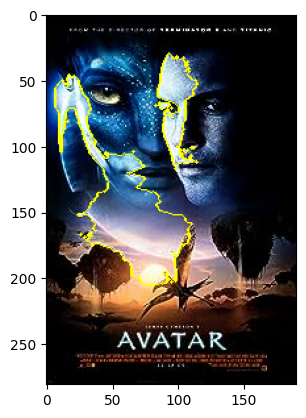

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

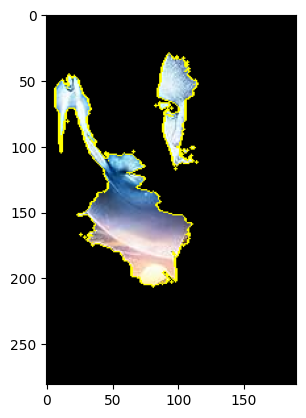

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries((temp/255.0), mask))

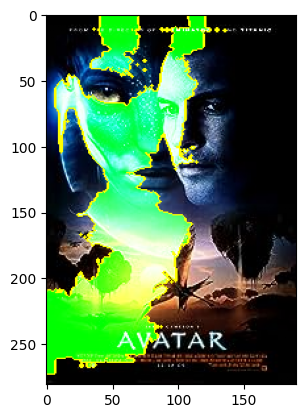

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

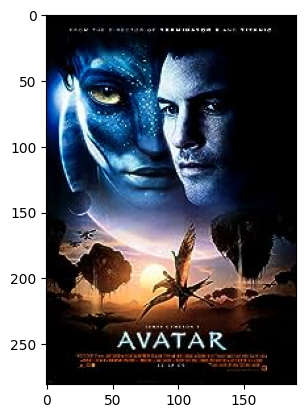

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.3)
plt.imshow(mark_boundaries(temp / 255.0, mask))

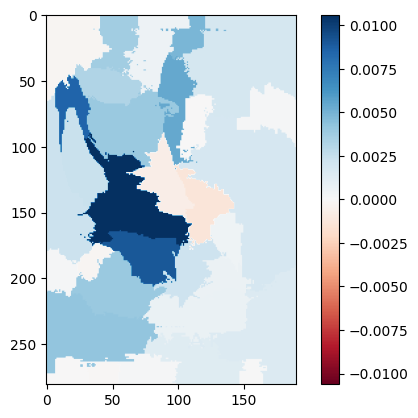

In [ ]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

### SHAP para imágenes

In [ ]:
import shap

[['Adventure' 'Horror' 'Foreign']]


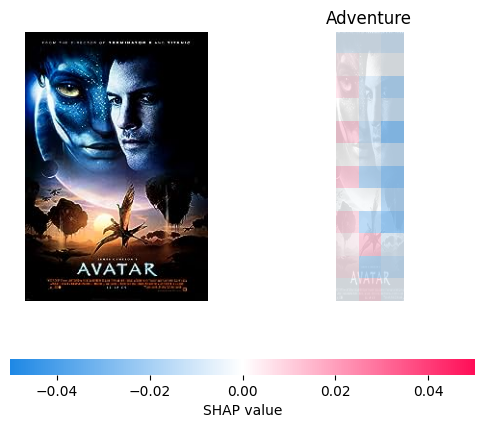

In [ ]:
transform = transforms.Compose([
    transforms.Resize((280, 190)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Cargar la imagen
img = Image.open('posters/Avatar.jpg').convert('RGB')
img_np = np.expand_dims(np.array(img), axis=0)
img_transformada = transform(img).unsqueeze(0)  # Añade una dimensión de batch
img_transformada = img_transformada.to(device)  # Mover la imagen al dispositivo adecuado
dataloader = DataLoader(dataset=train_dataset, batch_size=512, shuffle=True)
iterator = iter(dataloader)
one_batch, _ = next(iterator)

e = shap.GradientExplainer((model, model.layer4), one_batch.to(device))
shap_values, indexes = e.shap_values(img_transformada, ranked_outputs=3, nsamples=200)

# get the names for the classes
index_names = np.vectorize(lambda x: indice_a_clase[x])(indexes.cpu())
print(index_names)

# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, img_np, index_names)

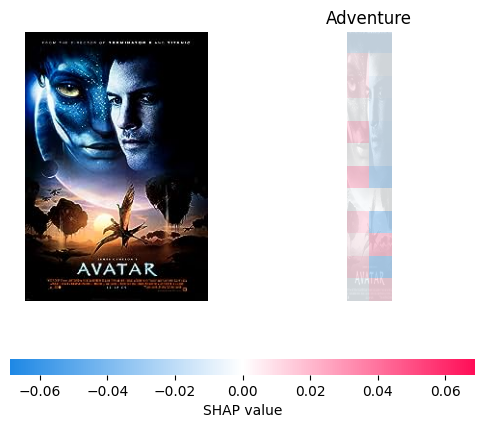

In [ ]:
# note that because the inputs are scaled to be between 0 and 1, the local smoothing also has to be scaled
explainer = shap.GradientExplainer(
    (model, model.layer4), img_transformada, local_smoothing=0.5
)
shap_values, indexes = explainer.shap_values(
    img_transformada, ranked_outputs=2, nsamples=200
)

# get the names for the classes
index_names = np.vectorize(lambda x: indice_a_clase[x])(indexes.cpu())

# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, img_np, index_names)

### Realize a continuación el análisis mediante SHAP

Aplique ambas técnicas en su versión para imágenes. Comente todos los resultados en detalle y las visualizaciones que genere. Compare estos resultados con las predicciones que obtuvo anteriormente. Recuerde que en los apartados previos las probabilidades si eran mayores de 0.5 se convierten a un valor de 1, puede ser interesante no realizar esta conversión para que pueda obervar que géneros son los que proprocionan las probabilidades más altas.

In [ ]:
# Desarrolle aquí el código para aplicar LIME y SHAP a las imágenes seleccionadas. Añada todas las celdas de texto que considere para comentar los resultados

In [ ]:
salida = model(img_transformada)

probabilidades = torch.sigmoid(salida)  # Aplica sigmoide si tu modelo no lo incluye
#etiquetas_predichas = (probabilidades > 0.5).int()  # Umbral para clasificación binaria

# Supongamos que tienes un diccionario que mapea índices a nombres de géneros
indice_a_clase = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama',
 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery',
 'Romance', 'Science Fiction', 'Thriller', 'War', 'Western']

# Obtener los nombres de clases para las etiquetas predichas
nombres_clases = [indice_a_clase[i] for i, etiqueta in enumerate(probabilidades.squeeze().tolist()) if etiqueta == 1]
print(nombres_clases)

[]


  0%|          | 0/1000 [00:00<?, ?it/s]

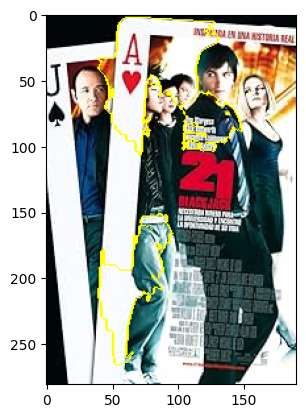

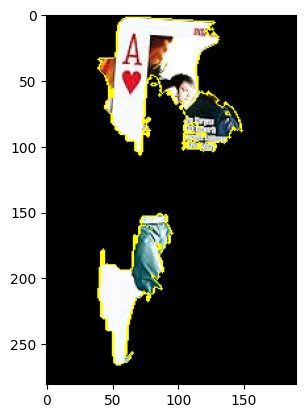

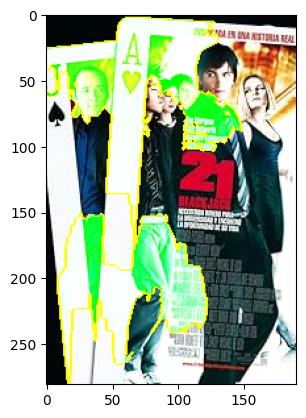

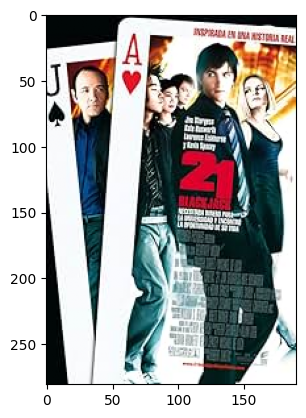

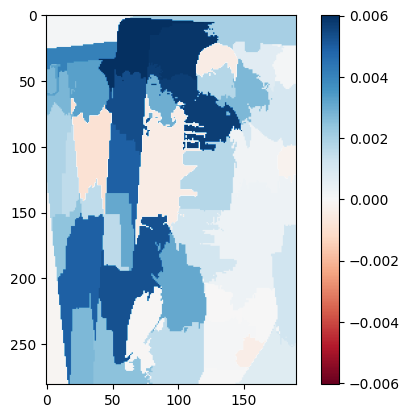

  0%|          | 0/1000 [00:00<?, ?it/s]

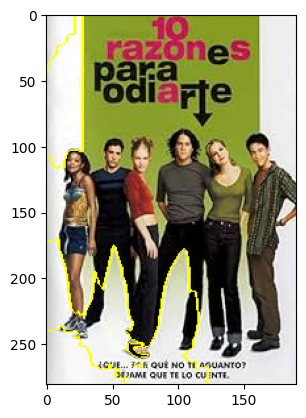

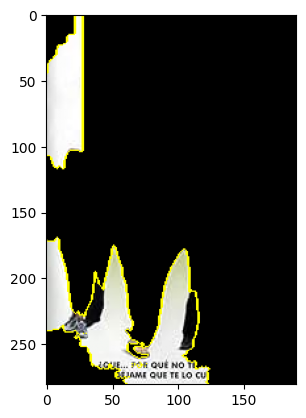

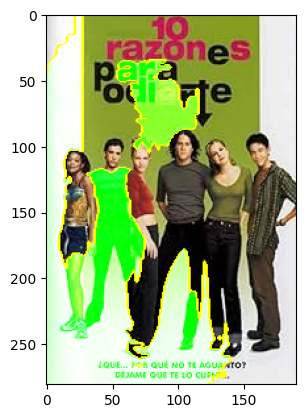

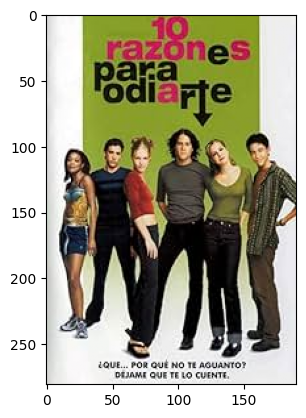

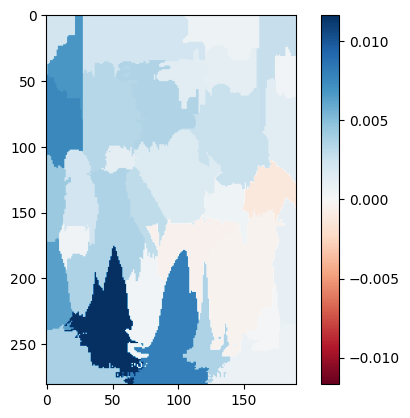

  0%|          | 0/1000 [00:00<?, ?it/s]

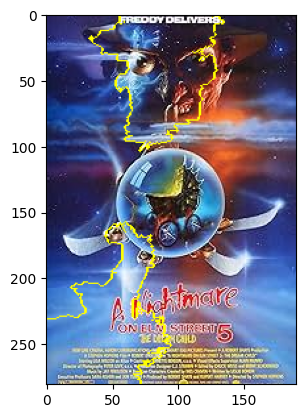

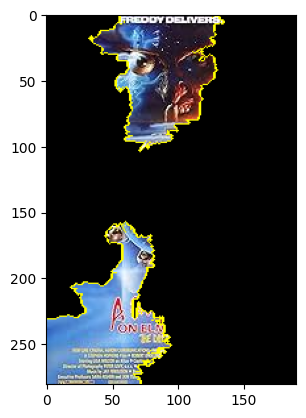

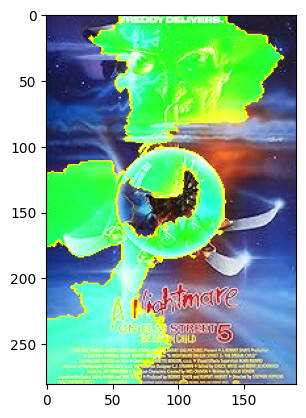

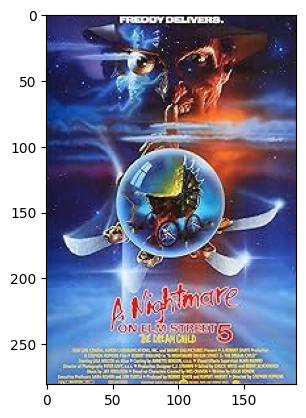

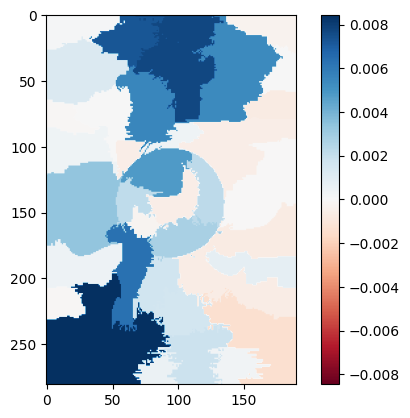

  0%|          | 0/1000 [00:00<?, ?it/s]

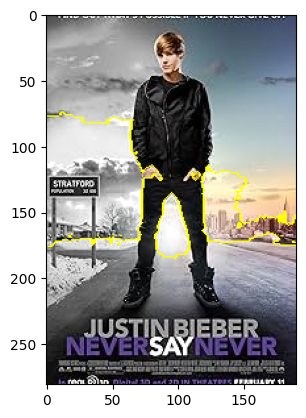

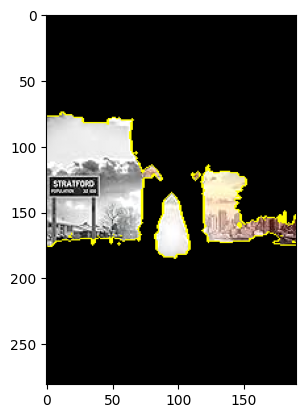

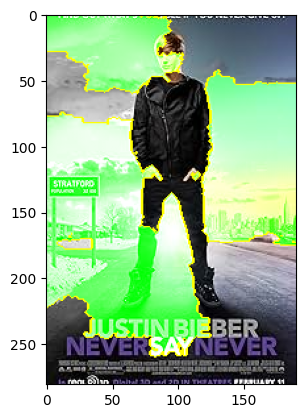

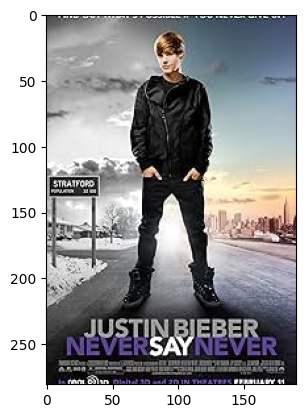

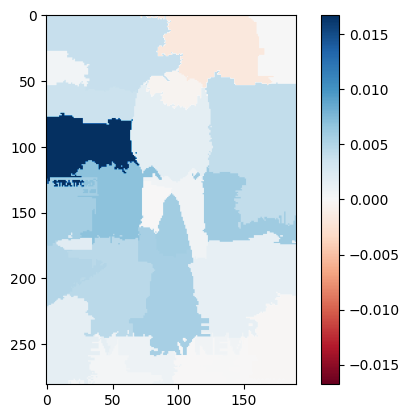

  0%|          | 0/1000 [00:00<?, ?it/s]

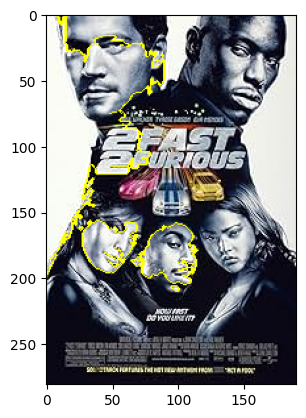

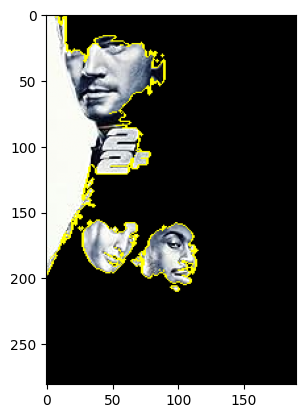

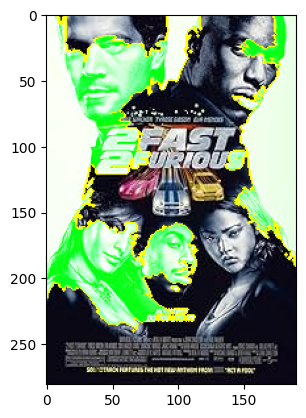

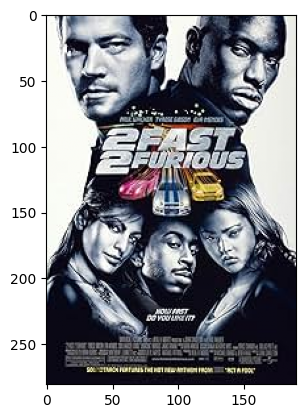

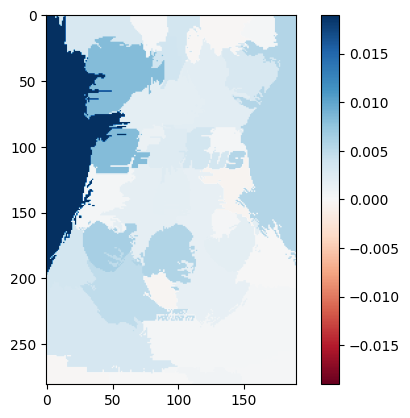

In [ ]:
for poster in poster_paths:
  input_img = Image.open(poster).convert('RGB')

# La imagen ya debe ser cargada y convertida a un arreglo NumPy adecuadamente
  input_array = np.array(input_img)

  explainer = lime_image.LimeImageExplainer()
  explanation = explainer.explain_instance(input_array,
                                         batch_predict, # función de clasificación
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000) # número de imágenes que se enviarán a la función de clasificación
  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
  img_boundry1 = mark_boundaries(temp/255.0, mask)
  plt.figure()
  plt.imshow(img_boundry1)
  plt.show()
  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
  plt.figure()
  plt.imshow(mark_boundaries((temp/255.0), mask))
  plt.show()
  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
  img_boundry2 = mark_boundaries(temp/255.0, mask)
  plt.figure()
  plt.imshow(img_boundry2)
  plt.show()
  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.3)
  plt.figure()
  plt.imshow(mark_boundaries(temp / 255.0, mask))
  plt.show()
  ind =  explanation.top_labels[0]
  dict_heatmap = dict(explanation.local_exp[ind])
  heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
  plt.figure()
  plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
  plt.colorbar()
  plt.show()

[['Adventure' 'Horror' 'Romance']]


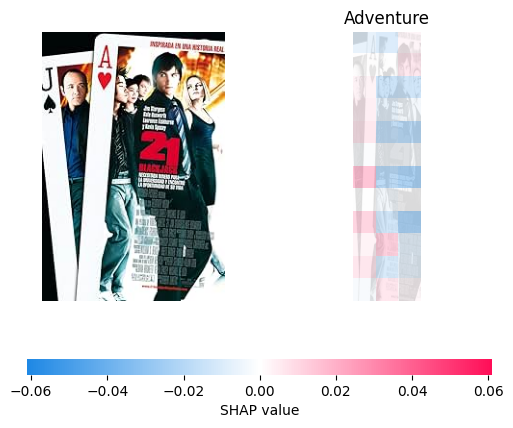

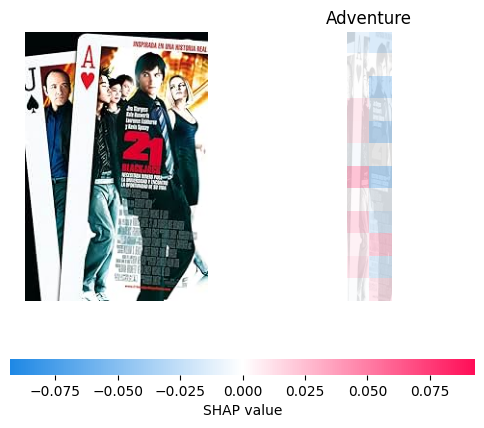

[['Adventure' 'Horror' 'Romance']]


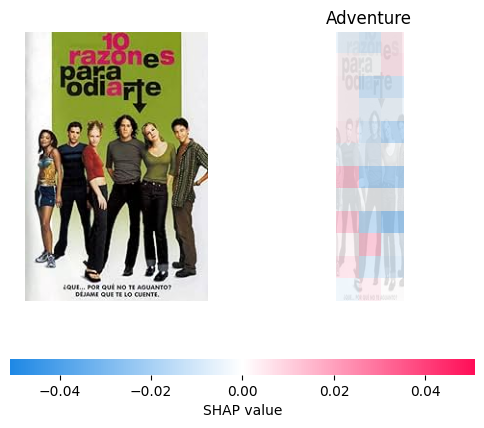

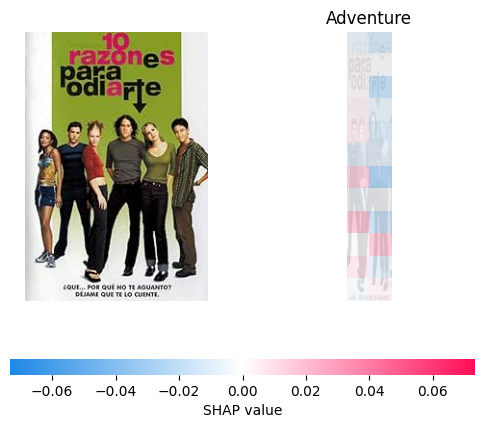

[['Adventure' 'Horror' 'Foreign']]


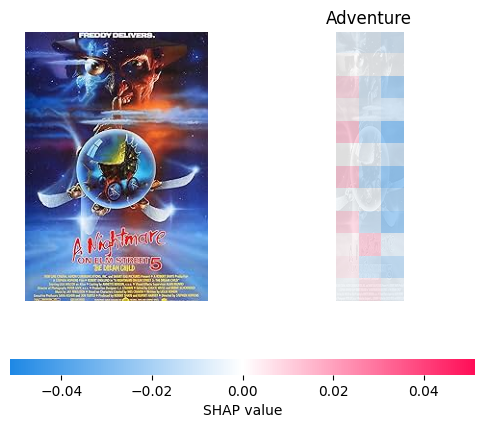

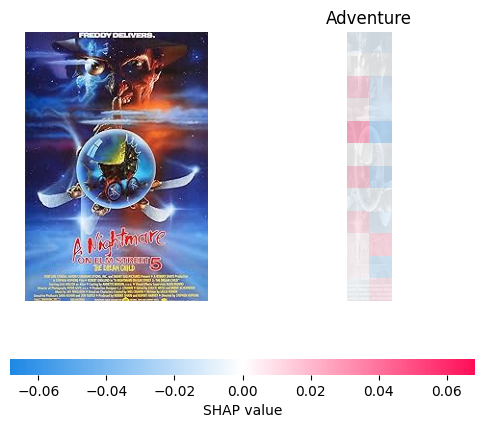

[['Adventure' 'Horror' 'Foreign']]


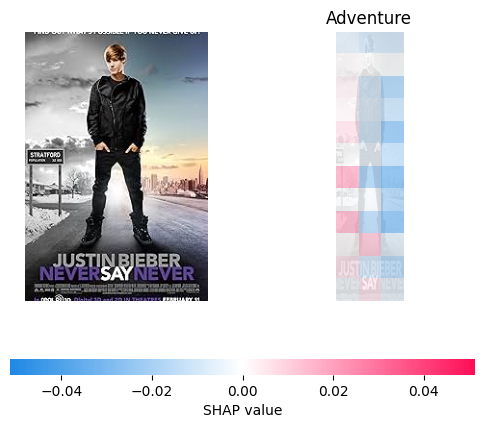

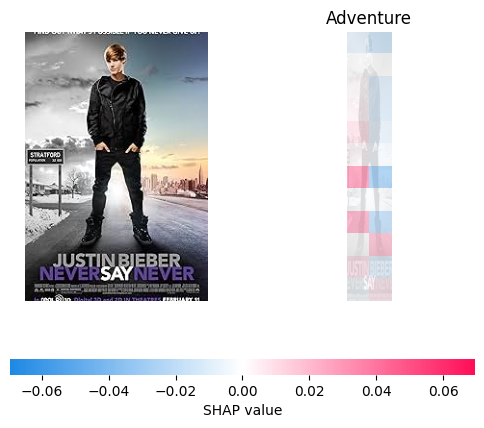

[['Adventure' 'Horror' 'Romance']]


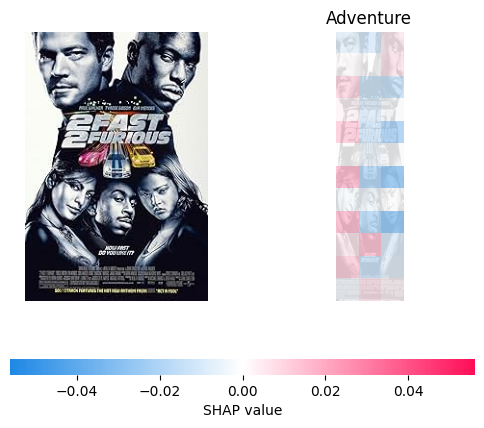

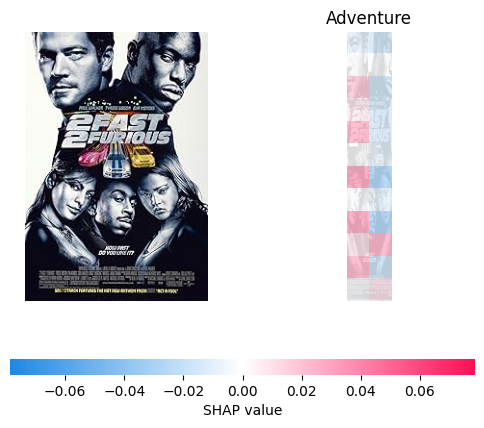

In [ ]:
transform = transforms.Compose([
    transforms.Resize((280, 190)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

for poster in poster_paths:
  img = Image.open(poster).convert('RGB')
  img_np = np.expand_dims(np.array(img), axis=0)
  img_transformada = transform(img).unsqueeze(0)  # Añade una dimensión de batch
  img_transformada = img_transformada.to(device)  # Mover la imagen al dispositivo adecuado
  dataloader = DataLoader(dataset=train_dataset, batch_size=512, shuffle=True)
  iterator = iter(dataloader)
  one_batch, _ = next(iterator)

  e = shap.GradientExplainer((model, model.layer4), one_batch.to(device))
  shap_values, indexes = e.shap_values(img_transformada, ranked_outputs=3, nsamples=200)
  index_names = np.vectorize(lambda x: indice_a_clase[x])(indexes.cpu())
  print(index_names)
  shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

  shap.image_plot(shap_values, img_np, index_names)
  explainer = shap.GradientExplainer(
      (model, model.layer4), img_transformada, local_smoothing=0.5
  )
  shap_values, indexes = explainer.shap_values(
      img_transformada, ranked_outputs=2, nsamples=200
  )
  index_names = np.vectorize(lambda x: indice_a_clase[x])(indexes.cpu())
  shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

  shap.image_plot(shap_values, img_np, index_names)

Al eliminar el umbral de 0.5 para la clasificación binaria, podemos observar directamente las probabilidades de pertenencia a cada género, proporcionadas por el modelo. En este caso, al usar LIME y posteriormente SHAP, vemos que predice todas las películas como 'Adventure'. Sin embargo, no todas ellas son de dicho género, esto nos da a entender que el modelo no es bueno para este conjunto de imágenes, ya que tiene un sesgo hacia esa clase.